In [ ]:
!wget https://raw.githubusercontent.com/caroljmcdonald/SparkStreamingHBaseExample/master/data/sensordata.csv

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
plt.style.use('ggplot')

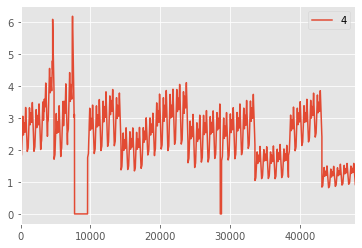

In [2]:
# Load the data
data = pd.read_csv('sensordata.csv', engine='python', usecols=[4], header=None)

# Plot the data
data.plot()
plt.show()

In [3]:
def rmse_of_current_segment(data):
    data = np.array(data)
    slope = (data[-1] - data[0]) / data.shape[0]
    intercept = data[0]
    y_hat = slope * data + intercept
    rmse = np.sqrt(np.mean((y_hat - data) ** 2))
    return rmse

In [4]:
# Sliding-windows
threshold = 0.5
segments = list()
current = list()
rmses = list()
for entry in tqdm(data.values[:]):
    current.append(entry[0])
    if len(current) > 2 and rmse_of_current_segment(current) > threshold:
        current.pop()
        segments.append(current)
        rmses.append(rmse_of_current_segment(current))
        current = [entry[0]]
segments.append(current)
rmses.append(rmse_of_current_segment(current))
print(len(segments))

100%|██████████████████████████████████████████████████████████████████████████| 47900/47900 [00:05<00:00, 9358.86it/s]


52


In [5]:
print(f"Number of segments by Sliding Window: {len(segments)}")
print(f"Sliding Window total RMSE: {np.sum(rmses)}")

Number of segments by Sliding Window: 52
Sliding Window total RMSE: 24.918326730919254


In [6]:
# Sliding-windows + bottom-up
threshold = 0.5
buffer_size = 2000
buffer = list()
segments = list()
current = list()
rmses = list()
for entry in tqdm(data.values[:]):
    if len(current) <= 2:
        current.append(entry[0])
        continue

    buffer.append(entry[0])
    if rmse_of_current_segment(current + buffer) < threshold:
        current += buffer
        buffer = list()
    elif len(buffer) > buffer_size:
        segments.append(current)
        rmses.append(rmse_of_current_segment(current))
        current = buffer
        buffer = list()

segments.append(current)
rmses.append(rmse_of_current_segment(current))
if len(buffer) != 0:
    segments.append(buffer)
    rmses.append(rmse_of_current_segment(buffer))
print(len(segments))

100%|██████████████████████████████████████████████████████████████████████████| 47900/47900 [00:11<00:00, 4245.00it/s]


20


In [7]:
print(f"Number of segments by Sliding Window: {len(segments)}")
print(f"Sliding Window total RMSE: {np.sum(rmses)}")

Number of segments by Sliding Window: 20
Sliding Window total RMSE: 15.719049029042765


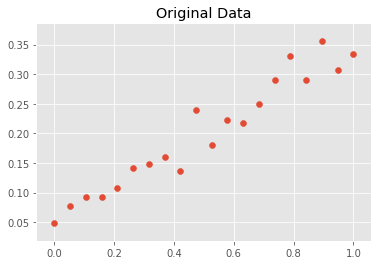

In [8]:
x = np.linspace(0, 1, 20)
y = 0.3 * x + np.random.random(20) * 0.1
plt.scatter(x, y)
plt.title("Original Data")
plt.show()

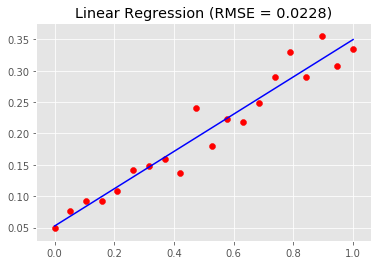

In [9]:
A = np.vstack((np.ones(x.shape), x)).T
beta = np.linalg.inv((A.T.dot(A))).dot(A.T).dot(y)
y_hat = A.dot(beta)
rmse = np.sqrt(np.mean((y_hat - y) ** 2))
plt.plot(x, A.dot(beta), color='b')
plt.scatter(x, y, color='r')
plt.title("Linear Regression (RMSE = %.4f)" % rmse)
plt.show()

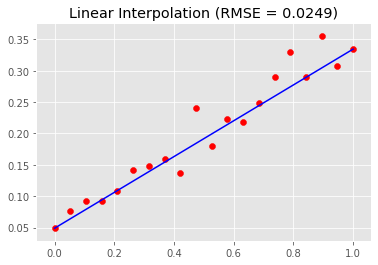

In [10]:
x_ = np.array([x[0], x[-1]])
y_ = np.array([y[0], y[-1]])
plt.plot(x_, y_, color='b')
plt.scatter(x, y, color='r')
A = np.vstack((np.ones(x_.shape), x_)).T
beta = np.linalg.inv((A.T.dot(A))).dot(A.T).dot(y_)

A = np.vstack((np.ones(x.shape), x)).T
y_hat = A.dot(beta)
rmse = np.sqrt(np.mean((y_hat - y) ** 2))
plt.title("Linear Interpolation (RMSE = %.4f)" % rmse)
plt.show()